In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_timeseries(metric, label):
    args  = {'skiprows' : 13, 'names': ["index", "Time (sec)", label]}
    fname = '../results/' + metric + '.wsp.out'
    try:
        df = pd.read_csv(fname, **args)
    except:
        sys.exit("Create time series (" + fname + ") does not exist, "+
                 "please cd to experiments/baseline-compile/visualize and run ./plot.sh")    
    del df['index']
    df = df[df['Time (sec)'] != 0]
    return df

# annotate graph with job phases
def plot_phases(ax, df, fname, jobs=['untar', 'make', 'rm'], y0=2000, y1=13000):
    def to_seconds(timestamp):
        ts = timestamp.split(':')
        return int(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    
    runtimes = pd.read_csv(fname)
    runtimes['label'] = ['download', 'untar', 'config', 'make', 'ls', 'rm']    
    t = int(df['Time (sec)'].head(1))    
    for index, row in runtimes.iterrows():
        sec = to_seconds(row['delta'])
        if row['label'] in jobs:
            ax.annotate(row['label'], xy=(t, y0), xytext=(t, y1),
                        ha='center', arrowprops=dict(facecolor='black'))
        t += sec

def trim(mod, axis):
    for i in range(0, len(axis)):
        if i % mod != 0:
            axis[i] = ""
    axis[0] = ""
    return axis

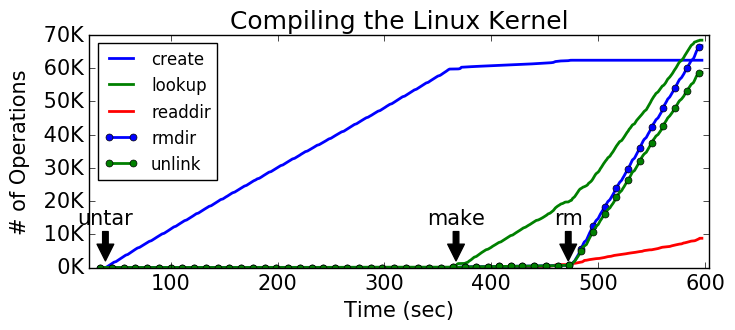

In [3]:
# parse into data frames
df = read_timeseries('req_create', 'create')
for req in ['readdir', 'lookup', 'unlink', 'rmdir']:
    df = pd.merge(df, read_timeseries('req_'+req, req), on='Time (sec)')
df = df[df['create'] > 11] # lop off the beginning of the trace

# plot the graph
font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
args = {'ax': ax, 'x': 'Time (sec)', 'lw': 2, 'colors': ['blue', 'green', 'red']}
df.plot(y=['create', 'lookup', 'readdir'], **args)
df.plot(y=['rmdir', 'unlink'], marker='o', markersize=5, markevery=10, **args)      
plot_phases(ax, df, '../results/compile-threads-4-node-5-2017-12-11-20:15:24.txt')

# format
ax.set_ylabel("# of Operations")
ax.set_yticklabels(['{:3.0f}K'.format(y/1000) for y in ax.get_yticks()])
ax.set_xticklabels(range(0, 1000, 100))
#ax.set_xlim(1513045534 - 100, 1513045534 + 570)
ax.set_xlim(1513045534 - 10, 1513045534 + 570)
ax.set_title("Compiling the Linux Kernel") 
ax.legend(fontsize=12, loc='upper left')
fig.savefig('../../../paper/figures/compile-ops.png', bbox_inches='tight', dpi=400)

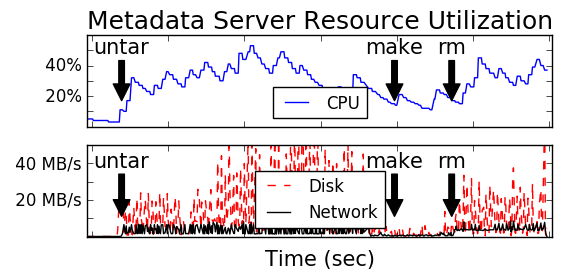

In [4]:
# annotate graph with job phases
def plot_phases(ax, df, fname, jobs=['untar', 'make', 'rm'], y0=2000, y1=13000):
    def to_seconds(timestamp):
        ts = timestamp.split(':')
        return int(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    
    runtimes = pd.read_csv(fname)
    runtimes['label'] = ['download', 'untar', 'config', 'make', 'ls', 'rm']    
    t = int(df['Time (sec)'].head(1))    
    for index, row in runtimes.iterrows():
        sec = to_seconds(row['delta'])
        if row['label'] in jobs:
            if row['label'] == 'make':
                ax.annotate(row['label'], xy=(t+30, y0), xytext=(t+30, y1),
                            ha='center', arrowprops=dict(facecolor='black'))                
            else:
                ax.annotate(row['label'], xy=(t, y0), xytext=(t, y1),
                            ha='center', arrowprops=dict(facecolor='black'))
        t += sec

# parse into data frames
df_util = read_timeseries('avg1', 'CPU')
for req in ['kbin', 'kbout', 'node1-sdc', 'node2-sdc', 'node3-sdc']:
    df_util = pd.merge(df_util, read_timeseries(req, req), on='Time (sec)')
df_util['Network'] = df_util['kbin'] + df_util['kbout']
df_util['Disk'] = df_util['node1-sdc'] + df_util['node2-sdc'] + df_util['node3-sdc']

# plot the graph
fig, ax = plt.subplots(2, 1, figsize=(6, 2.6))
args = {'x': 'Time (sec)', 'lw': 1}#, 'colors': ['blue', 'green', 'red']}
df_util.plot(ax=ax[0], y=['CPU'], **args)
df_util.plot(ax=ax[1], y=['Disk'], color='red', ls='--', **args)
#y2 = ax[1].twinx()
y2 = ax[1]
df_util.plot(ax=y2, y=['Network'], color='black', **args)

# add arrows
job = '../results/compile-threads-4-node-5-2017-12-11-20:15:24.txt'
plot_phases(ax[0], df, job, y0=0.17, y1=0.48)
plot_phases(ax[1], df, job, y0=11000, y1=38000)

# format
for a in ax:
    a.set_xlabel("")
    a.set_xticklabels([])
    a.set_xlim(1513045534 - 40, 1513045534 + 570)       
ax[0].legend(fontsize=12, loc='lower center')
ax[0].set_title("Metadata Server Resource Utilization")
#ax[0].set_ylabel("", fontsize=12)
ax[0].set_ylim(0, 0.6)
ax[0].set_yticklabels(trim(2, ['{:3.0f}%'.format(y*100) for y in ax[0].get_yticks()]), fontsize=12)
#ax[1].set_ylabel("MB/s", fontsize=12)
ax[1].set_ylim(0, 50000)
ax[1].set_yticklabels(trim(2, ['{:3.0f} MB/s'.format(y/1000) for y in ax[1].get_yticks()]), fontsize=12)
ax[1].legend(fontsize=12, loc='lower center')
ax[1].set_xlabel("Time (sec)")
fig.savefig('../../../paper/graphs/overhead-creates.png', bbox_inches='tight', dpi=400)